# ANALIZA FOREX TRŽIŠTA



Forex ili FX tržište, dolazi od engleskih riječi __for__eign i __ex__change, a označava devizno tržište. Dnevni opseg trgovanja na Forex tržištu je 5,5 bilijuna dolara i ono je najlikvidnije i najtransparentnije tržište na svijetu. Osim valutnih parova, moguće je trgovati s naftom, zlatom, srebrom i drugim plemenitim metalima te mnogim drugim financijskim instrumentima. Trgovina se odvija preko platforme, dok je posrednik kompanija čiju platformu koristite.

U ovom radu, na temelju prošlih podataka, pokušat ćemo predvidjeti buduće podatke koristeći SVM regresiju, te ćemo  izračunati korelacije podataka za razne parove parova valuta.
Na kraju ćemo za svaki nacrtati pripadne grafove i donijeti zaključak.



## Analiza podataka


Podaci su preuzeti preko programa _MetaTrader 4 Admiral Markets_ i spremljeni u mapu _Podaci_.
Odabrani podaci prikazuju 30-minutni interval trgovanja glavnim valutama, odnosno sve parove valuta: američki dolar (USD), euro od Europske ekonomske zajednice (EUR), japanski jen (JPY), britanska funta (GBP), švicarski franak (CHF) i australijski dolar (AUD).

Značajke podataka su: 
1. Time - vremenski period trgovanja (ovdje je 30-minutni period)
2. Open - cijena prve kupoprodajne operacije u određenom vremenskom periodu
3. High - najveća cijena parova valuta u zadanom intervalu
4. Low - najmanja cijena parova valuta u zadanom intervalu
5. Close - cijena zadnje transakcije izvršene u nekom određenom odsječku vremena
6. Volume - broj transakcija u zadanom intervalu

a izgled podataka je dan na sljedeći način:

In [1]:
!head Podaci/EURUSD30.csv
print("\n")
!head Podaci/AUDCHF30.csv

1971.01.04,00:00,0.53690,0.53690,0.53690,0.53690,1
1971.01.05,00:00,0.53660,0.53660,0.53660,0.53660,1
1971.01.06,00:00,0.53650,0.53650,0.53650,0.53650,1
1971.01.07,00:00,0.53680,0.53680,0.53680,0.53680,1
1971.01.08,00:00,0.53710,0.53710,0.53710,0.53710,1
1971.01.11,00:00,0.53710,0.53710,0.53710,0.53710,1
1971.01.12,00:00,0.53710,0.53710,0.53710,0.53710,1
1971.01.13,00:00,0.53730,0.53730,0.53730,0.53730,1
1971.01.14,00:00,0.53720,0.53720,0.53720,0.53720,1
1971.01.15,00:00,0.53760,0.53760,0.53760,0.53760,1


1993.05.14,00:00,1.01940,1.01940,1.01940,1.01940,1
1993.05.17,00:00,1.02950,1.02950,1.02950,1.02950,1
1993.05.18,00:00,1.02480,1.02480,1.02480,1.02480,1
1993.05.19,00:00,1.01950,1.01950,1.01950,1.01950,1
1993.05.20,00:00,1.02140,1.02140,1.02140,1.02140,1
1993.05.21,00:00,1.02100,1.02100,1.02100,1.02100,1
1993.05.24,00:00,1.02140,1.02140,1.02140,1.02140,1
1993.05.25,00:00,1.02170,1.02170,1.02170,1.02170,1
1993.05.26,00:00,1.01630,1.01630,1.01630,1.01630,1
1993.05.27,00:00,0.99140,0.99

In [2]:
import pandas as pd

names = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']

valute = 'EUR GBP AUD USD CHF JPY'.split()

tablice = {val1 + val2: pd.read_csv(f'Podaci/{val1}{val2}30.csv', names=names)
           for i1, val1 in enumerate(valute) for i2, val2 in enumerate(valute) if i1 < i2}

AUDCHF = tablice["AUDCHF"].copy()

AUDCHF.head()

,Date,Time,Open,High,Low,Close,Volume
0,1993.05.14,00:00,1.0194,1.0194,1.0194,1.0194,1
1,1993.05.17,00:00,1.0295,1.0295,1.0295,1.0295,1
2,1993.05.18,00:00,1.0248,1.0248,1.0248,1.0248,1
3,1993.05.19,00:00,1.0195,1.0195,1.0195,1.0195,1
4,1993.05.20,00:00,1.0214,1.0214,1.0214,1.0214,1


In [3]:
if(AUDCHF["Time"] != "00:00").any():
    print(AUDCHF.loc[AUDCHF["Time"] != "00:00", :].head(1))  
print("\nNpr. Za par AUD_CHF 30-minutni interval trgovanja bilježi se od 1.5.2007.,\ndok je prva transakcija obavljena 14.5.1993.\n")

            Date   Time    Open    High     Low   Close  Volume
3398  2007.05.01  00:30  1.0015  1.0015  1.0009  1.0009      70

Npr. Za par AUD_CHF 30-minutni interval trgovanja bilježi se od 1.5.2007.,
dok je prva transakcija obavljena 14.5.1993.



Zbog različitih početaka trgovanja raznim valutama usredotočit ćemo se na podatke koji su dobiveni u jednakim vremenskim intervalima kako bismo ih mogli uspoređivati. Radi preglednijeg grafičkog prikaza analizirat ćemo podatke nastale u razdoblju od 1.1.2018. do 31.3.2018.


In [4]:
from datetime import datetime

def mergeDateAndTimeIntoOneColumn(tablica):
    toDateTime = lambda x : datetime.strptime(x, '%Y.%m.%d  %H:%M')

    tablica['Date&Time'] = tablica['Date'].map(str) + " " + tablica['Time'].map(str)
    tablica['Date&Time'] = [toDateTime(x) for x in tablica['Date&Time']]
    del tablica['Date'], tablica['Time']

    tablica.index = tablica['Date&Time']
    del tablica['Date&Time']
    
    return tablica

for naziv, tablica in tablice.items():
    mergeDateAndTimeIntoOneColumn(tablica)

#### Grafovi za svaki par valuta za _Open_ i _Close_ vrijednosti

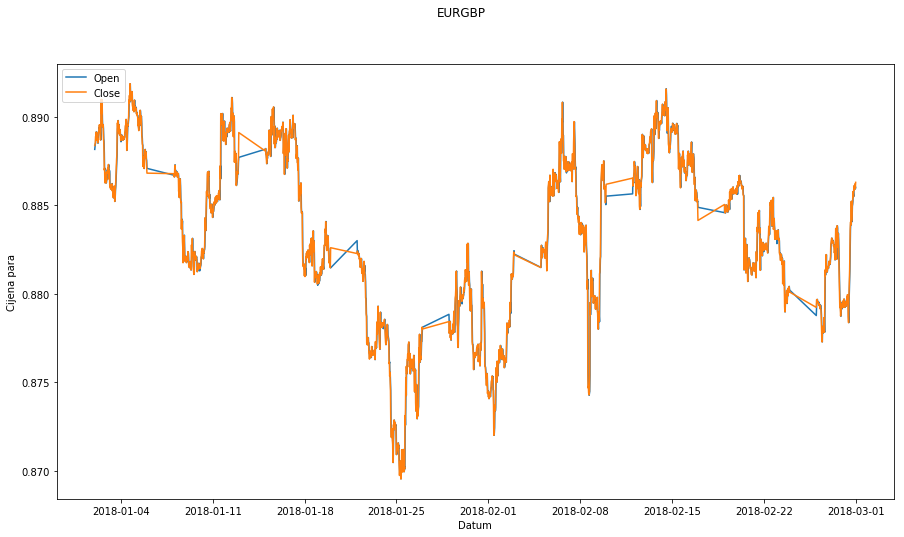

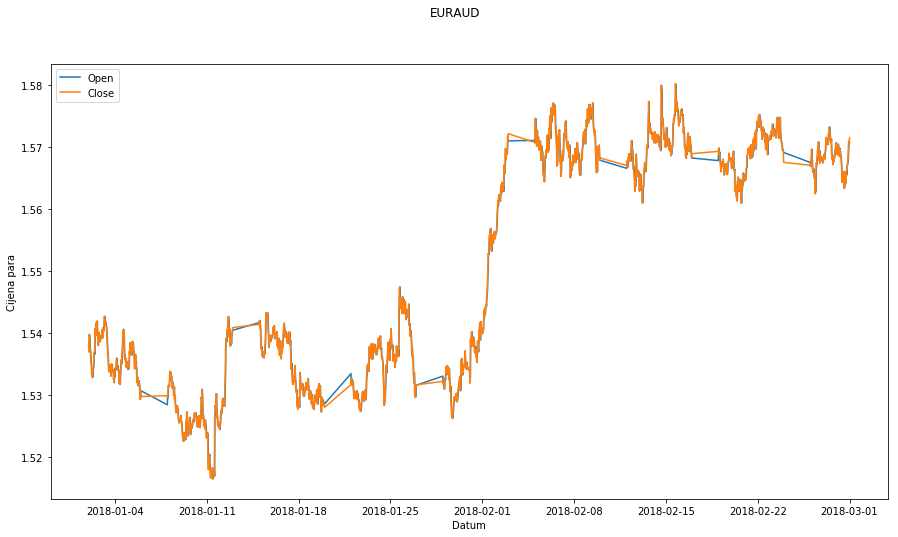

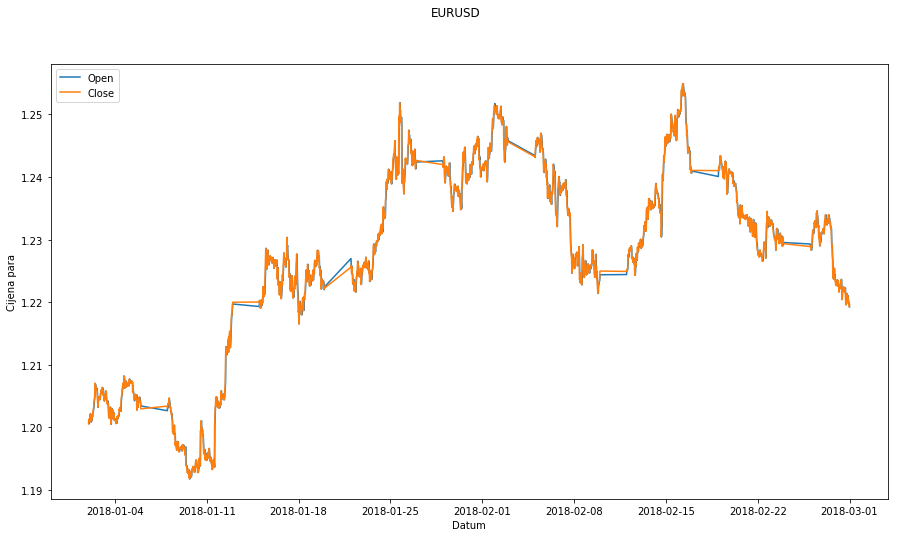

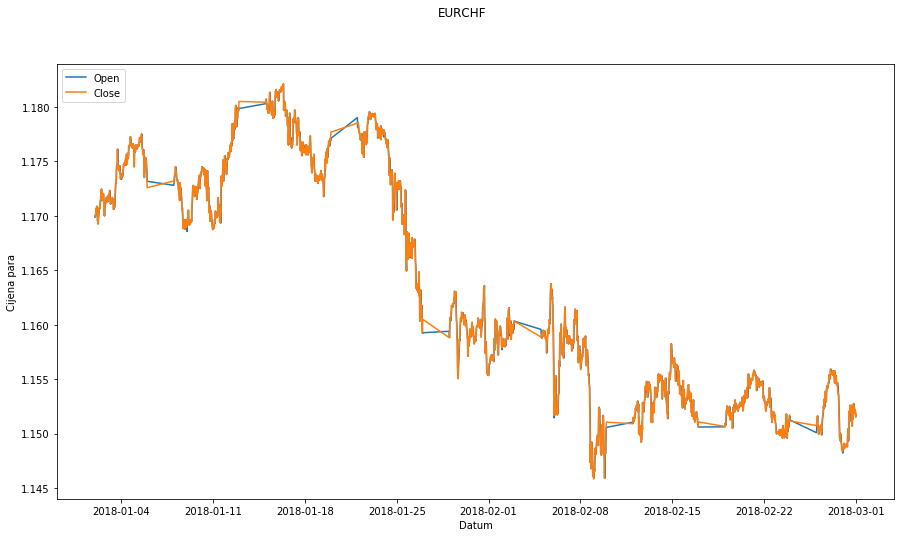

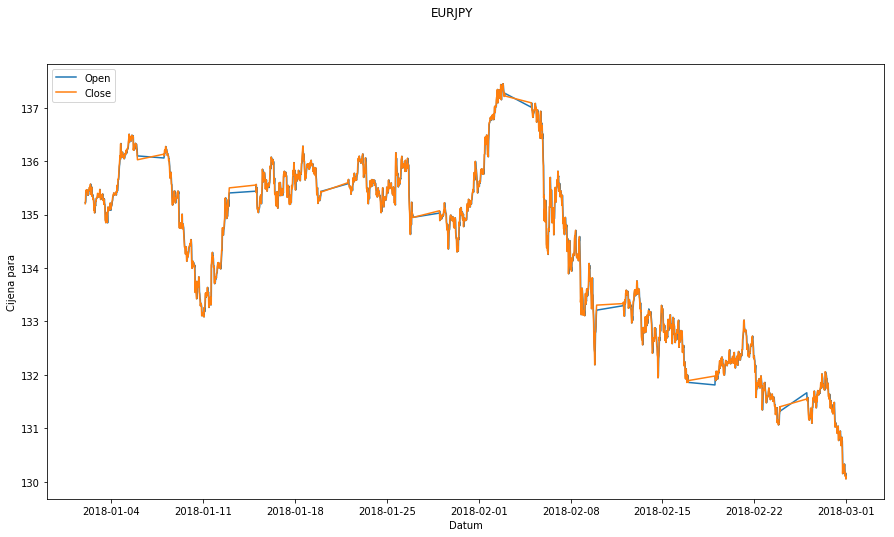

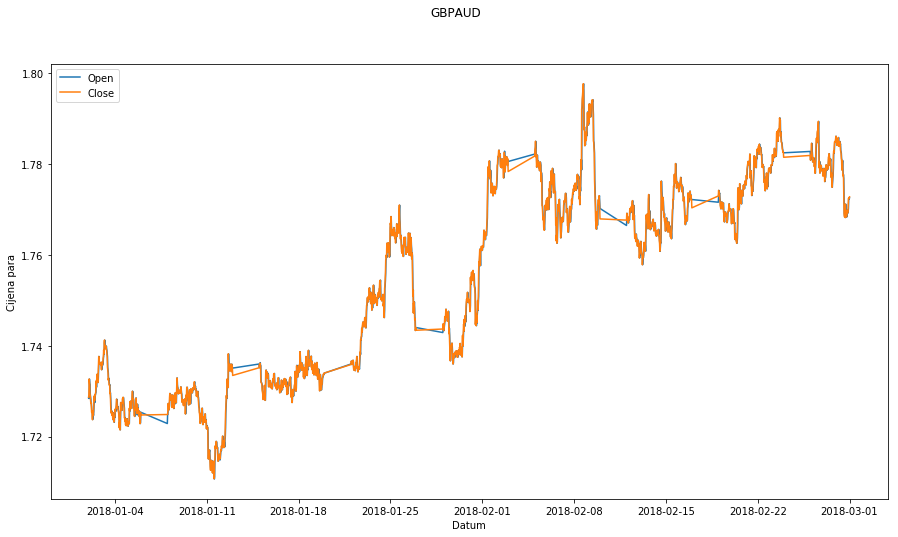

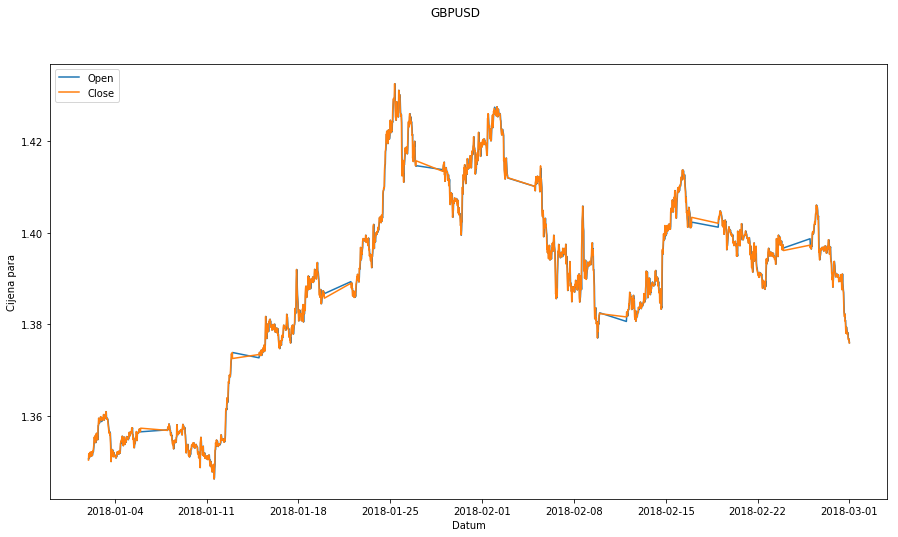

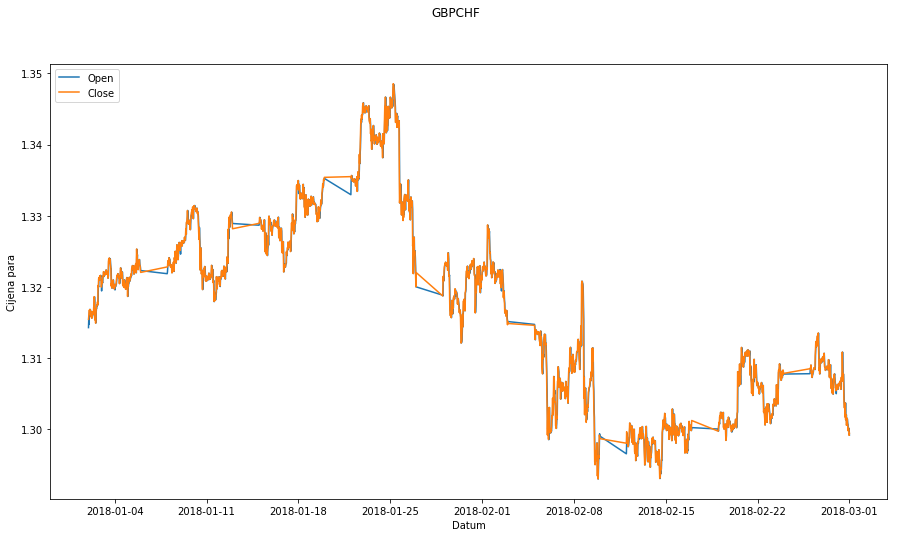

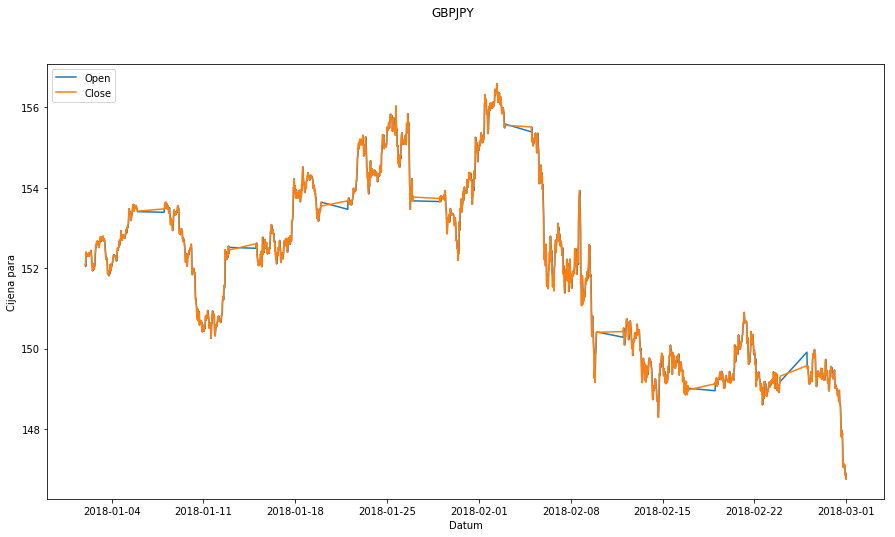

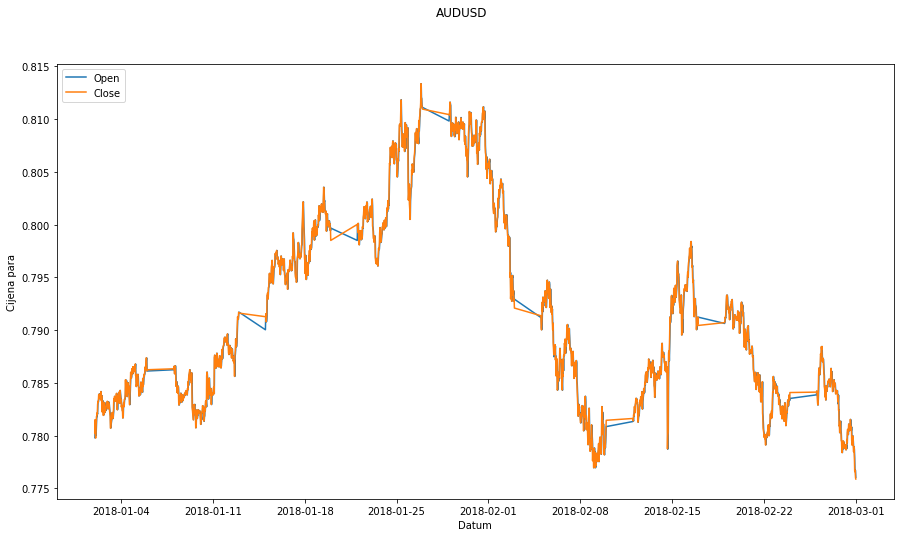

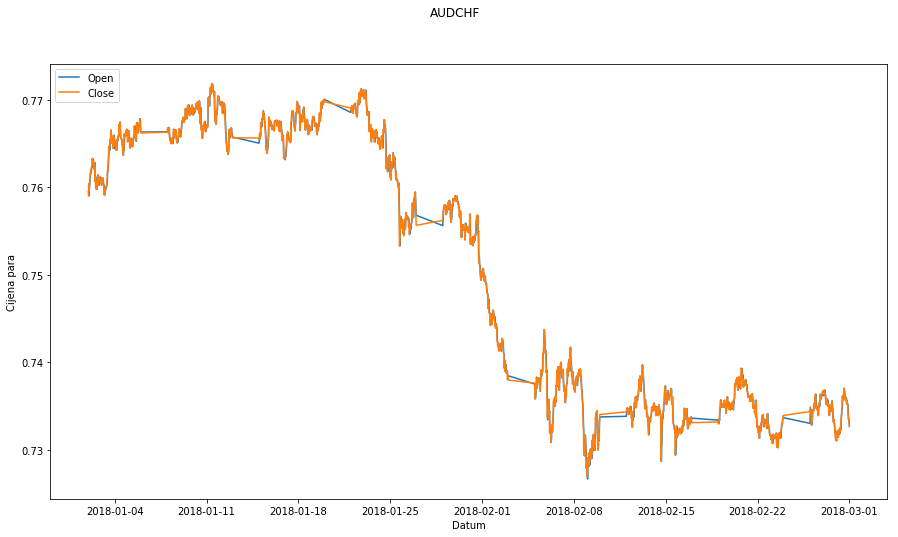

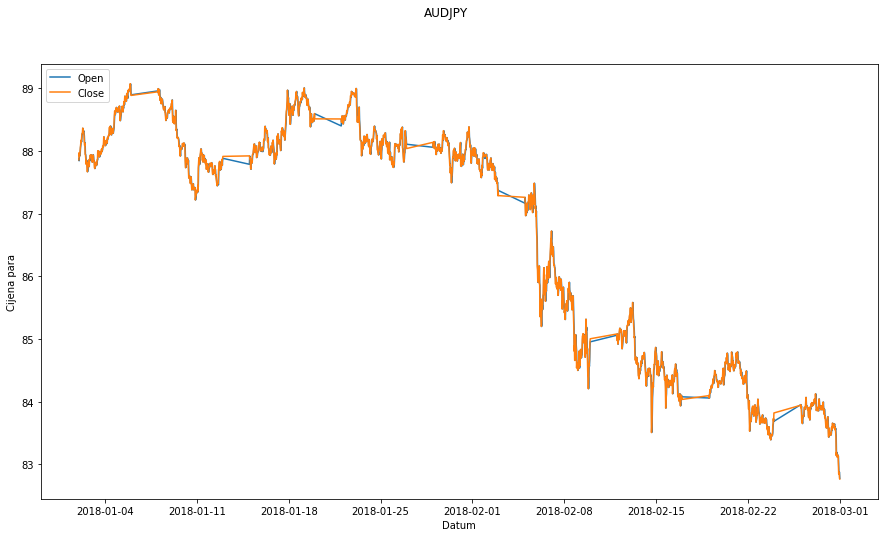

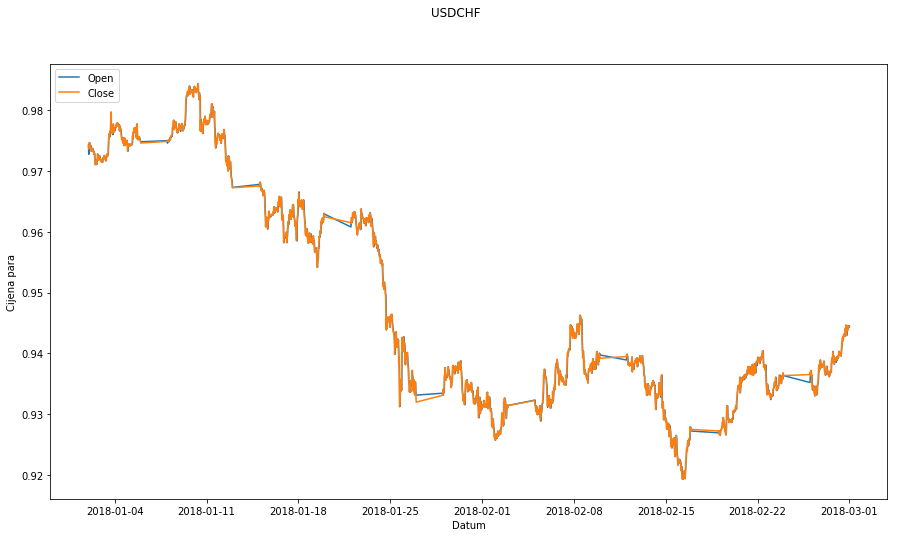

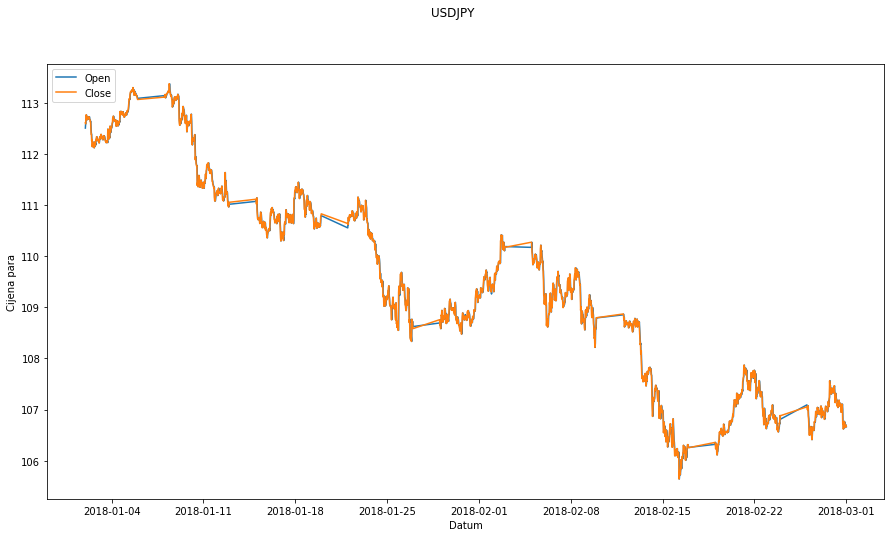

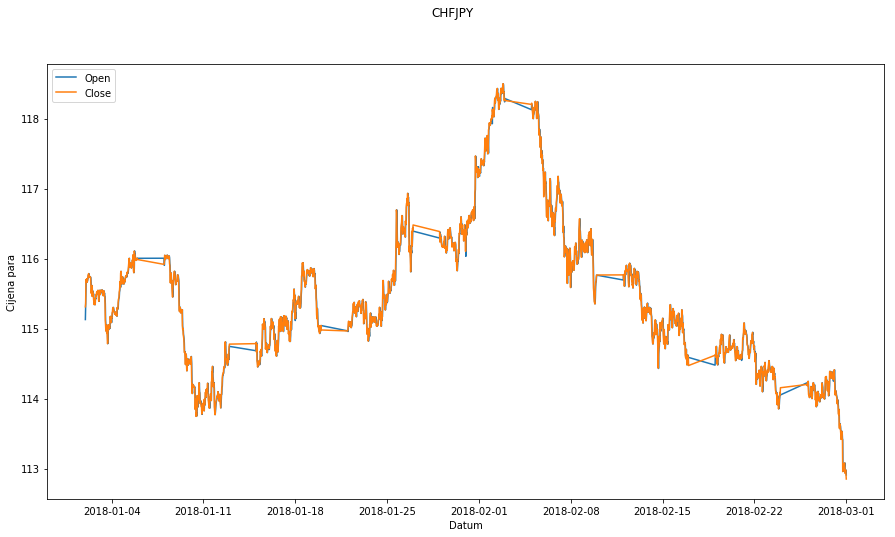

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab

def plotanje(tablica, naslov):
    fig = plt.subplots(figsize=(15,8))
    pylab.plot(tablica[['Open']], label='Open')
    pylab.plot(tablica[['Close']], label='Close')
    pylab.suptitle(naslov)
    pylab.xlabel('Datum')
    pylab.ylabel('Cijena para')
    pylab.legend(loc='upper left')
    pylab.show()

tabliceNovijegDatuma = tablice.copy() 
for naziv, tablica in tabliceNovijegDatuma.items():
    tabliceNovijegDatuma[naziv] = tablica[datetime(2018, 3, 1):datetime(2018, 4, 4)]

for naziv, tablica in tablice.items():
    tablice[naziv] = tablica[datetime(2018, 1, 1):datetime(2018, 3, 1)]
    
for naziv, tablica in tablice.items():
    plotanje(tablica, naziv)

In [6]:
from functools import reduce

def renameColumns(tablica, name):
    tablica = tablica.rename(
                    columns={
                    "Open" : "Open_" + name,
                    "High" : "High_" + name,
                    "Low" : "Low_" + name,
                    "Close" : "Close_" + name,
                    "Volume" : "Volume_" + name}
                           )
    return tablica

for naziv, tablica in tablice.items():
    tablice[naziv] = renameColumns(tablica, naziv)
    
for naziv, tablica in tabliceNovijegDatuma.items():
    tabliceNovijegDatuma[naziv] = renameColumns(tablica, naziv)

In [7]:
spojenaTablica = reduce(lambda left,right: left.join(right), [y for x, y in tablice.items()])
spojenaTablica

,Open_EURGBP,High_EURGBP,Low_EURGBP,Close_EURGBP,Volume_EURGBP,Open_EURAUD,High_EURAUD,Low_EURAUD,Close_EURAUD,Volume_EURAUD,...,Open_USDJPY,High_USDJPY,Low_USDJPY,Close_USDJPY,Volume_USDJPY,Open_CHFJPY,High_CHFJPY,Low_CHFJPY,Close_CHFJPY,Volume_CHFJPY
Date&Time,,,,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00,0.88816,0.88875,0.88722,0.88838,38,1.53766,1.53899,1.53740,1.53816,205,...,112.503,112.663,112.503,112.607,340,115.129,115.528,115.129,115.311,105
2018-01-02 00:30:00,0.88833,0.88883,0.88833,0.88844,210,1.53818,1.53965,1.53643,1.53692,318,...,112.590,112.603,112.579,112.586,485,115.327,115.484,115.253,115.356,507
2018-01-02 01:00:00,0.88846,0.88881,0.88810,0.88852,1374,1.53739,1.54000,1.53677,1.53976,2003,...,112.591,112.736,112.588,112.735,1494,115.506,115.739,115.436,115.698,1442
2018-01-02 01:30:00,0.88852,0.88897,0.88843,0.88889,849,1.53975,1.54070,1.53938,1.53976,821,...,112.736,112.779,112.714,112.764,848,115.688,115.734,115.656,115.661,555
2018-01-02 02:00:00,0.88885,0.88918,0.88873,0.88887,360,1.53919,1.53991,1.53906,1.53916,440,...,112.761,112.784,112.731,112.747,298,115.660,115.719,115.646,115.701,249
2018-01-02 02:30:00,0.88879,0.88917,0.88847,0.88914,535,1.53911,1.53913,1.53738,1.53776,819,...,112.725,112.769,112.714,112.728,784,115.679,115.738,115.676,115.713,469
2018-01-02 03:00:00,0.88915,0.88919,0.88893,0.88902,552,1.53777,1.53826,1.53729,1.53731,1242,...,112.727,112.742,112.651,112.663,688,115.710,115.732,115.655,115.661,684
2018-01-02 03:30:00,0.88906,0.88917,0.88899,0.88904,241,1.53718,1.53727,1.53579,1.53641,735,...,112.666,112.720,112.661,112.713,448,115.666,115.701,115.664,115.684,220
2018-01-02 04:00:00,0.88902,0.88907,0.88872,0.88873,295,1.53667,1.53668,1.53525,1.53529,732,...,112.712,112.739,112.708,112.722,794,115.683,115.706,115.674,115.688,380


In [8]:
spojenaTablicaNova = reduce(lambda left,right: left.join(right), [y for x, y in tabliceNovijegDatuma.items()])
spojenaTablicaNova

,Open_EURGBP,High_EURGBP,Low_EURGBP,Close_EURGBP,Volume_EURGBP,Open_EURAUD,High_EURAUD,Low_EURAUD,Close_EURAUD,Volume_EURAUD,...,Open_USDJPY,High_USDJPY,Low_USDJPY,Close_USDJPY,Volume_USDJPY,Open_CHFJPY,High_CHFJPY,Low_CHFJPY,Close_CHFJPY,Volume_CHFJPY
Date&Time,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,0.88602,0.88643,0.88541,0.88630,2640,1.57071,1.57231,1.57022,1.57147,1652,...,106.662,106.698,106.609,106.671,1828,112.909,112.966,112.765,112.851,2109
2018-03-01 00:30:00,0.88630,0.88654,0.88602,0.88627,1249,1.57121,1.57180,1.57042,1.57119,3257,...,106.671,106.710,106.643,106.654,4803,112.851,112.951,112.837,112.882,3297
2018-03-01 01:00:00,0.88628,0.88659,0.88621,0.88650,1111,1.57118,1.57158,1.57029,1.57111,2730,...,106.649,106.660,106.587,106.614,2046,112.859,112.919,112.839,112.869,1206
2018-03-01 01:30:00,0.88650,0.88674,0.88627,0.88631,705,1.57111,1.57134,1.57017,1.57036,1569,...,106.613,106.694,106.603,106.635,1679,112.869,112.946,112.861,112.892,723
2018-03-01 02:00:00,0.88631,0.88648,0.88599,0.88621,1649,1.57039,1.57185,1.57002,1.57117,4601,...,106.636,106.669,106.563,106.608,5074,112.890,112.922,112.755,112.796,4083
2018-03-01 02:30:00,0.88622,0.88652,0.88615,0.88637,2187,1.57117,1.57545,1.57117,1.57508,6373,...,106.609,106.754,106.543,106.686,5312,112.796,112.910,112.739,112.870,4456
2018-03-01 03:00:00,0.88636,0.88674,0.88634,0.88659,1718,1.57508,1.57716,1.57386,1.57714,5131,...,106.686,106.764,106.563,106.604,5904,112.871,112.952,112.742,112.786,4473
2018-03-01 03:30:00,0.88659,0.88669,0.88634,0.88647,2009,1.57714,1.57760,1.57620,1.57668,4943,...,106.606,106.722,106.590,106.646,5181,112.787,112.872,112.756,112.827,4269
2018-03-01 04:00:00,0.88648,0.88681,0.88620,0.88675,1999,1.57668,1.57928,1.57656,1.57801,4265,...,106.645,106.694,106.598,106.686,3517,112.826,112.826,112.750,112.821,2845


## Korelacije valutnih parova

__Valutna korelacija__ je mjera uzajamne ovisnosti dvaju valutnih parova. __Koeficijent korelacije__ predstavljen je u decimalnom formatu i varira od +1.0 do -1.0.
Korelacija +1 (pozitivno, izravno) znači da se dva valutna para premještaju 100% vremena u jednom smjeru.
Korelacija -1 (negativno, inverzno) znači da se dva para 100% vremena kreću u suprotnim smjerovima.
Nula (0) korelacija znači da dva para ne ovise jedni o drugima.
Korelacija valutnih parova ovisi o stanju na financijskom tržištu, a to znači da se može mijenjati periodično.

In [9]:
def izracunajKorelacije(naziv, tablica):
    filter_col = [col for col in tablica if col.startswith(naziv)]
    return tablica[filter_col].corr(method='pearson') 

naziviStupaca = list(set(names) - set(['Date', 'Time']))

tabliceKorelacija = {naziv : izracunajKorelacije(naziv, spojenaTablica)
                     for naziv in naziviStupaca}

In [10]:
tabliceKorelacija['Close']

,Close_EURGBP,Close_EURAUD,Close_EURUSD,Close_EURCHF,Close_EURJPY,Close_GBPAUD,Close_GBPUSD,Close_GBPCHF,Close_GBPJPY,Close_AUDUSD,Close_AUDCHF,Close_AUDJPY,Close_USDCHF,Close_USDJPY,Close_CHFJPY
Close_EURGBP,1.000000,0.137229,-0.357823,0.098113,-0.141149,-0.313983,-0.649479,-0.462017,-0.510889,-0.535185,-0.035978,-0.157116,0.286183,0.154788,-0.286701
Close_EURAUD,0.137229,1.000000,0.555688,-0.832685,-0.575517,0.897289,0.401787,-0.816696,-0.552664,-0.413972,-0.968351,-0.883728,-0.764357,-0.770831,0.034205
Close_EURUSD,-0.357823,0.555688,1.000000,-0.526926,-0.077577,0.690956,0.942398,-0.271418,0.073375,0.526692,-0.569369,-0.352367,-0.916828,-0.743633,0.410610
Close_EURCHF,0.098113,-0.832685,-0.526926,1.000000,0.678371,-0.841249,-0.462440,0.837163,0.550735,0.273394,0.944446,0.850144,0.822304,0.819050,-0.058249
Close_EURJPY,-0.141149,-0.575517,-0.077577,0.678371,1.000000,-0.488672,-0.010429,0.681575,0.923111,0.501310,0.644870,0.891293,0.372292,0.724178,0.693804
Close_GBPAUD,-0.313983,0.897289,0.690956,-0.841249,-0.488672,1.000000,0.673634,-0.576360,-0.302001,-0.159446,-0.911799,-0.776963,-0.859133,-0.807008,0.160122
Close_GBPUSD,-0.649479,0.401787,0.942398,-0.462440,-0.010429,0.673634,1.000000,-0.053928,0.244650,0.622109,-0.449027,-0.228541,-0.848191,-0.659470,0.438318
Close_GBPCHF,-0.462017,-0.816696,-0.271418,0.837163,0.681575,-0.576360,-0.053928,1.000000,0.771141,0.538666,0.860976,0.843251,0.574497,0.643447,0.105094
Close_GBPJPY,-0.510889,-0.552664,0.073375,0.550735,0.923111,-0.302001,0.244650,0.771141,1.000000,0.644724,0.573632,0.834740,0.210858,0.567474,0.714017
Close_AUDUSD,-0.535185,-0.413972,0.526692,0.273394,0.501310,-0.159446,0.622109,0.538666,0.644724,1.000000,0.366236,0.516524,-0.222850,-0.027571,0.412724


In [11]:
tabliceKorelacija['Volume']

,Volume_EURGBP,Volume_EURAUD,Volume_EURUSD,Volume_EURCHF,Volume_EURJPY,Volume_GBPAUD,Volume_GBPUSD,Volume_GBPCHF,Volume_GBPJPY,Volume_AUDUSD,Volume_AUDCHF,Volume_AUDJPY,Volume_USDCHF,Volume_USDJPY,Volume_CHFJPY
Volume_EURGBP,1.000000,0.911825,0.956717,0.903563,0.849311,0.933718,0.965081,0.946063,0.840991,0.826647,0.904584,0.791449,0.916699,0.700954,0.838390
Volume_EURAUD,0.911825,1.000000,0.952316,0.899959,0.910025,0.959635,0.896665,0.896593,0.906312,0.918080,0.947651,0.912509,0.902442,0.815640,0.903576
Volume_EURUSD,0.956717,0.952316,1.000000,0.923086,0.895713,0.922663,0.934926,0.920193,0.851351,0.865312,0.932815,0.839575,0.940729,0.759421,0.873820
Volume_EURCHF,0.903563,0.899959,0.923086,1.000000,0.865696,0.876155,0.873325,0.873084,0.827513,0.835518,0.905460,0.820387,0.923496,0.755438,0.842850
Volume_EURJPY,0.849311,0.910025,0.895713,0.865696,1.000000,0.874579,0.826074,0.805221,0.916915,0.864179,0.869275,0.910780,0.866417,0.892821,0.896589
Volume_GBPAUD,0.933718,0.959635,0.922663,0.876155,0.874579,1.000000,0.939558,0.928705,0.917895,0.887028,0.933273,0.868898,0.896294,0.774164,0.897673
Volume_GBPUSD,0.965081,0.896665,0.934926,0.873325,0.826074,0.939558,1.000000,0.959750,0.838289,0.818262,0.898258,0.771859,0.912740,0.679075,0.833938
Volume_GBPCHF,0.946063,0.896593,0.920193,0.873084,0.805221,0.928705,0.959750,1.000000,0.819701,0.772708,0.916036,0.765881,0.904983,0.656201,0.850489
Volume_GBPJPY,0.840991,0.906312,0.851351,0.827513,0.916915,0.917895,0.838289,0.819701,1.000000,0.853310,0.866010,0.923380,0.833601,0.907940,0.928459
Volume_AUDUSD,0.826647,0.918080,0.865312,0.835518,0.864179,0.887028,0.818262,0.772708,0.853310,1.000000,0.890628,0.922199,0.865954,0.849913,0.851456


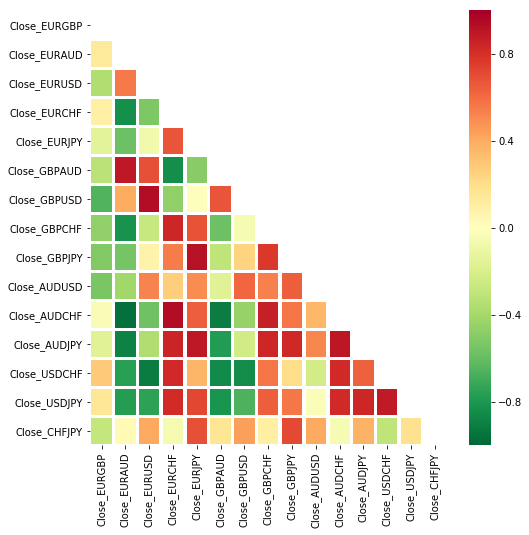

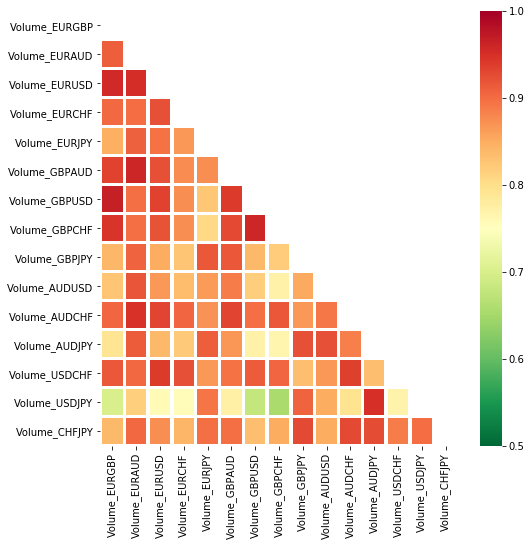

In [12]:
import numpy as np
import seaborn

def grafKorelacija(tablica, naziv, velmin, velmax):
    mask = np.zeros_like(tablica[naziv])
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(8,8))
    seaborn.heatmap(tablica[naziv], cmap='RdYlGn_r', vmax=velmax, vmin=velmin, mask = mask, linewidths=2.5)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90) 
    plt.show()
    
intervali = [[-1, 1], [0.5, 1]]
for naziv, [imin, imax] in zip(['Close', 'Volume'], intervali):
    grafKorelacija(tabliceKorelacija, naziv, imin, imax)

Iz grafičkog prikaza i tablice korelacije valutnih parova za cijene zadnje transakcije (**_Close_** vrijednosti) uočavamo da<br/>
__vrlo jaku pozitivnu korelaciju__ imaju sljedeći parovi 
1. CHF_JPY i EUR_JPY s koeficijentom korelacije 0.95
2. CHF_JPY i AUD_JPY s koeficijentom korelacije 0.90
3. AUD_JPY i EUR_JPY s koeficijentom korelacije 0.90
4. AUD_JPY i AUD_CHF s koeficijentom korelacije 0.90

__Jaku inverznu korelaciju__ imaju parovi
1. EUR_GBP i GBP_CHF s koeficijentom korelacije -0.85
2. USD_CHF i EUR_USD s koeficijentom korelacije -0.84
3. USD_CHF i GBP_USD s koeficijentom korelacije -0.81
4. EUR_GBP i GBP_USD s koeficijentom korelacije -0.80
5. EUR_GBP i GBP_AUD s koeficijentom korelacije -0.80

__Vrlo slabu korelaciju__ imaju parovi
1. CHF_JPY i EUR_USD s koeficijentom korelacije -0.01
2. GBP_CHF i EUR_CHF s koeficijentom korelacije 0.02
3. AUD_USD i EUR_CHF s koeficijentom korelacije 0.02

Ako pogledamo **_Volume_** vrijednosti, odnosno broj transakcija opažamo da se najmanji broj transakcija odvija između parova USD_JPY i GBP_CHF, a najveći između parova EUR_USD i EUR_AUD, GBP_USD i EUR_GBP, EUR_CHF i EUR_USD.

## Predviđanje kretanja valuta korištenjem metode potpornih vektora (SVM)

_Metoda potpornih vektora_ (__SVM__) je skup metoda za nadzirano ucenje korišten za klasifikaciju, regresiju i detekciju outlier-a. SVM traži optimalnu ravninu (hiperravninu) razdvajanja koja maksimizira marginu razdvajanja. (_Margina_ je udaljenost između “kritičnih” točaka neke klase najbliže blizu plohi razdvajanja.)

U regresiji SVM-a potrebno je procijeniti funkcionalnu ovisnost zavisne varijable $y$ na skupu nezavisnih varijabli $x$. Pretpostavljamo da je odnos između nezavisnih i zavisnih varijabli određen determinističkom funkcijom $f$ uz dodatak nekog šuma.

Podatke dijelimo na _trening_ skup i _test_ skup. Trening skup podataka služi za učenje SVM algoritma u svrhu što bolje klasifikacije podataka. Za razliku od trening skupa, test skup služi za mjerenje performansi modela kojeg smo trenirali.

U našem slučaju podatke ćemo podijeliti tako da se 80% podataka koristi za treniranje, a 20% za testiranje.

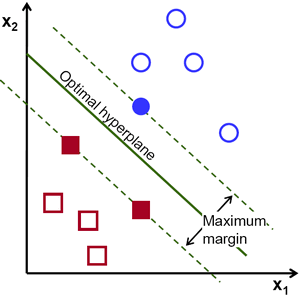

In [13]:
from IPython.display import Image
Image('https://docs.opencv.org/2.4/_images/optimal-hyperplane.png')

### Matematička formulacija SVM regresije

$$y = f(x) + noise$$

Potrebno je pronaći odgovarajući oblik funkcije $f$ koja može ispravno predvidjeti nova stanja koja SVM-u nisu bila poznata od ranije. To se može postići treniranjem SVM modela na jednostavnom skupu (_trening skup_), a taj proces osim klasifikacije uključuje sekvencijalnu optimizaciju funkcije pogreške. Ovisno kako definiramo funkciju pogreške, postoje dva tipa SVM algoritma: 

* Za trening vektore $x_i \in {\rm I\!R}^p, i = 1,...,n$ i vektor $ y \in \{1, -1\}^n $, SVM rješava problem minimizacije funkcije pogreške
$$\frac{1}{2}w^Tw + C \sum_{i=1}^n \zeta_i + C \sum_{i=1}^n \zeta_i^\boldsymbol{\cdot},$$
gdje je $$w^T\Phi(x_i) + b - y_i \leq \varepsilon + \zeta_i^\boldsymbol{\cdot},$$
$$y_i - w^T\Phi(x_i) - b_i \leq \varepsilon + \zeta_i,$$ 
$$\zeta_i^\boldsymbol{\cdot},\zeta_i \geq 0, i = 1,...,n,$$
dok je $\Phi$ funkcija koja mapira trening vektor u višedimenzionalni prostor. $C$ je konstanta kapaciteta, $w$ je vektor koeficijenata, $b$ je konstanta, $\zeta_i$ predstavlja parametre za rukovanje neodvojivim podacima (ulazima). Indeks $i$ označava $N$ trening stanja.

* Za ovaj SVM algoritam funkcija pogreške dana je s
$$\frac{1}{2}w^Tw - C\Big(\nu\varepsilon + \frac{1}{N} \sum_{i=1}^n (\zeta_i + \zeta_i^\boldsymbol{\cdot})\Big),$$
gdje je $$w^T\Phi(x_i) + b - y_i \leq \varepsilon + \zeta_i,$$
$$y_i - (w^T\Phi(x_i) + b_i) \leq \varepsilon + \zeta_i^\boldsymbol{\cdot},$$ 
$$\zeta_i^\boldsymbol{\cdot},\zeta_i \geq 0, i = 1,...,n, \varepsilon \geq 0.$$

Postoji više vrsta _krenela_ (jezgri) koji se mogu koristiti u SVM algoritmima. Uključuju linearne, polinomialne, radialne (RBF) i sigmoidalne funkcije:
\begin{equation*}
K(X_i, X_j) =  \begin{cases}
X_i\boldsymbol{\cdot}X_j & linear \\
(\gamma X_i\boldsymbol{\cdot}X_j + C)^d &  Polynomial \\
exp(-\gamma |X_i\boldsymbol - X_j|^2) &  RBF \\
tanh(\gamma X_i\boldsymbol{\cdot}X_j + C) &  Sigmoid
\end{cases}
\end{equation*}
_Kernel_ funkcija 
$$K(X_i, X_j)=\Phi(X_i)\boldsymbol{\cdot}\Phi(X_j)$$ 
predstavlja skalarni produkt ulaznih podataka mapiranih u višedimenzionalni prostor transformacijom $\Phi$.

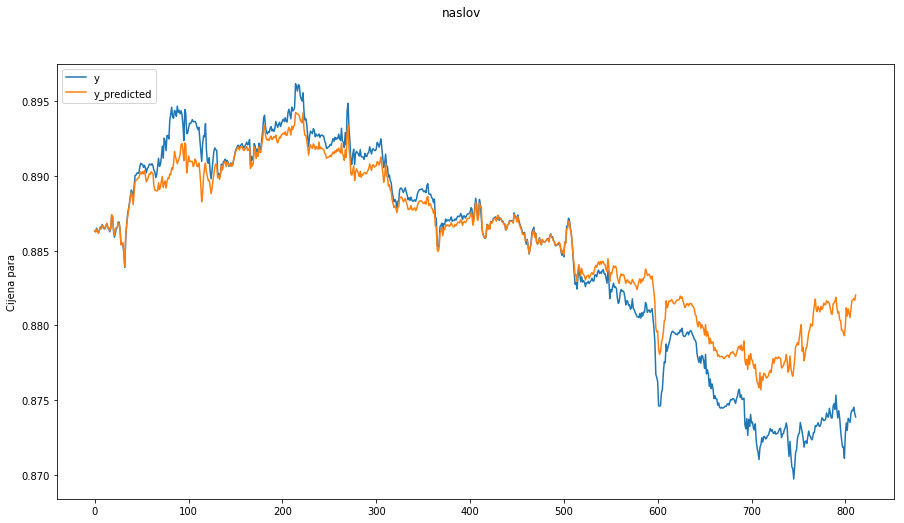

In [16]:
from sklearn.svm import SVR

def GetStupce(StupacPredikcija):
    return [col for col in spojenaTablica if col.startswith('Close') and StupacPredikcija not in col]

def PlotajGraf(y, y_predicted):
    fig = plt.subplots(figsize=(15,8))
    pylab.plot(y, label='y')
    pylab.plot(y_predicted, label='y_predicted')
    pylab.suptitle("naslov")
    #pylab.xlabel('Datum')
    pylab.ylabel('Cijena para')
    pylab.legend(loc='upper left')
    pylab.show()

def Nauci(StupacPredikcija):
    Stupci = GetStupce(StupacPredikcija)

    X = np.array(spojenaTablica[Stupci].values)
    X = np.array(X)
    #print (X.shape)

    y = np.array(spojenaTablica["Close_" + StupacPredikcija].values)
    #print (y.shape)

    #fitting the SVR to the dataset
    regressor = SVR(kernel = 'rbf', epsilon = 1e-10, tol = 1e-4)
    regressor.fit(X, y)
    
    #print(regressor)
    #print(regressor.score(X, y))
    return regressor


model = Nauci("EURGBP")
y = np.array(spojenaTablicaNova["Close_"+"EURGBP"])
y_predicted = model.predict(spojenaTablicaNova[GetStupce("EURGBP")])
PlotajGraf(y, y_predicted)

## Zaključak

TO DO

## Literatura

https://www.fortrade.eu/edukacija/sto-je-forex/

http://www.forex-internet.com/forex/rijecnik_pojmova.htm

https://www.fortrade.eu/edukacija/forex-rijecnik/

https://hr.id-forex.com/correlation-in-forex-market-application-advice

https://web.math.pmf.unizg.hr/nastava/su/index.php/download_file/-/view/174/

http://www.statsoft.com/Textbook/Support-Vector-Machines